# Introduction
1. Neural Machine Translation (NMT) is the task of using artificial neural network models for translation from one language to the other.  
2. The NMT model generally consists of an encoder that encodes a source sentence into a fixed-length vector from which a decoder generates a translation.  
3. This problem can be thought as a prediction problem, where given a sequence of words in source language as input, task is to predict the output sequence of words in target language.  
4. The dataset comes from http://www.manythings.org/anki/, where you may find tab delimited bilingual sentence pairs in different files based on the source and target language of your choice.  
5. For this project, I will be using French - English language pairs.  


# Importing All the Required Modules

In [508]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, GRU
from tensorflow.keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import os, sys, zipfile, nltk, keras, pydot, re
from collections import defaultdict
from IPython.display import clear_output

In [32]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000 # Total is around 220k, increase, only if sufficienct memory is available
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200
MODEL_NAME = 'seq2seq_eng-fra.h5' # Change this to load different models. Refer README.md

# Step-1: Download and Clean the Data

# Downloading the Dataset

In [3]:
!curl https://www.manythings.org/anki/fra-eng.zip -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7756k  100 7756k    0     0  4194k      0  0:00:01  0:00:01 --:--:-- 4192k


# Extracting the Zip File

In [4]:
# Path to the zip file
zip_file_path = 'data.zip'

# Destination folder where files will be extracted
extract_to = 'dataset\\'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete!")

Extraction complete!


# Reading and Cleaning the Data

We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.

In [3]:
def format_phrase(phrase):
    char_to_remove = '.!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~0123456789'
    for i in char_to_remove:
        phrase = phrase.replace(i, '') # Replace Unwanted Characters with Blank.
    return phrase

In [4]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('dataset\\fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = format_phrase(line.strip().split('\t')[0])
    output = format_phrase(line.strip().split('\t')[1])

    output_sentence = output + ' <eos>'
    output_sentence_input = '<eos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


In [5]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  Be fair
French translation:  Soyez honnêtes <eos>


__NOTE:__ We have added an <eos> character to identify the End of String while decoding output.

# Step-2: Split and prepare the data for training the model

The next stage is to tokenize the original and translated sentences and apply padding to those that are longer or shorter than a predetermined length, which in the case of inputs will be the length of the longest input sentence. This will be the length of the output's longest sentence in case of outputs.

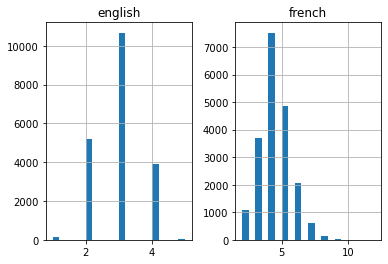

In [6]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

__The histogram above shows maximum length of the French sentences is 12 and that of the English sentence is 5.__  

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:  

<ol>
  <li> It divides a sentence into the corresponding list of word  
  <li> Then it converts the words to integers  
</ol>

Also the __word_index__ attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values.

In [7]:
#tokenize the input sentences(input language)
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print("First 5 Sequences: ", input_integer_seq[:5])

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

First 5 Sequences:  [[16], [16], [16], [16], [548]]
Total unique words in the input: 3325
Length of longest sentence in input: 5


In [8]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print("First 5 Sequences: ", output_input_integer_seq[:5])

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

First 5 Sequences:  [[1, 40], [1, 278], [1, 21, 341], [1, 447], [1, 708]]
Total unique words in the output: 7757
Length of longest sentence in the output: 12


Now the lengths of longest sentence can also be verified from the histogram above. And it can be concluded that English sentences are normally shorter and contain a smaller number of words on average, compared to the translated French sentences.

Next, we need to pad the input.

In [9]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (20000, 5)
encoder_input_sequences[180]: [  0   0   0  22 313]


Since there are 20,000 sentences in the input and each input sentence is of length 5, the shape of the input is now (20000, 5).  

You may recall that the original sentence at index 180 is 'be fair'. The tokenizer divided the sentence into two words be and fair, converted them to integers, and then applied pre-padding by adding three zeros at the start of the corresponding integer sequence for the sentence at index 180 of the input list.

To verify that the integer values for join and us are 22 and 313 respectively, you can pass the words to the word2index_inputs dictionary, as shown below:

In [10]:
print(word2idx_inputs["be"])
print(word2idx_inputs["fair"])

22
313


In the same way, the decoder outputs and the decoder inputs are padded.

In [11]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[180]: [   1   50 1463    0    0    0    0    0    0    0    0    0]


The sentence at index 180 of the decoder input is Soyez honnêtes. If you print the corresponding integers from the word2idx_outputs dictionary, you should see 50 and 1463 printed on the console.

In [12]:
print(word2idx_outputs["<eos>"])
print(word2idx_outputs["soyez"])
print(word2idx_outputs["honnêtes"])

1
50
1463


In [13]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

decoder_output_sequences.shape: (20000, 12)


# Word Embeddings
__We already converted our words into integers. So what's the difference between integer representation and word embeddings?__  

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.  

For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.  

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

## NOTE:
__Following step needs your Kaggle APIKey. Either execute the next block, or download the dataset directly from Kaggle to continue without executing the next block.__  
In case, you downloaded the dataset directly from Kaggle, without executing the next block, make sure the dataset is present in the same directory as this .ipynb file. Or, Change the File_Path in __glove_file__ object

In [17]:
import opendatasets as od

od.download(
	"https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mindhawk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt


100%|██████████| 778M/778M [00:28<00:00, 28.8MB/s]


In [14]:
embeddings_dictionary = dict()

glove_file = open(r'glovetwitter27b100dtxt\\glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = np.asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Recall that we have 3325 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.

In [15]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
print(embeddings_dictionary["be"])

[-7.2794e-01  4.1956e-01 -2.8589e-01  5.7387e-01  1.4630e-01 -1.2594e-01
  5.3598e-01  1.0132e-01 -3.1534e-02  4.3855e-01 -9.5961e-02 -3.9334e-01
 -1.0793e+00 -5.2205e-01 -3.9882e-02 -3.1034e-01  5.2148e-02  5.0650e-01
 -3.6776e-01  2.0845e-01 -1.6772e-01  3.4593e-01 -6.1488e-01 -7.2145e-02
 -1.4877e-01  9.4468e-01  3.2766e-01  1.3315e-01  2.6522e-01  5.0030e-02
 -2.6085e-02  8.0815e-02 -2.1716e-01 -4.1411e-02  7.6261e-02  2.2949e-01
  4.2087e-02 -1.5966e-01 -2.9075e-01 -3.0555e-01  5.6748e-01 -2.8637e-01
  1.1921e-01 -2.0725e-01  5.8126e-01 -5.7166e-01  2.4174e-01 -5.4495e-01
 -3.2589e-01  2.0344e-01  1.9583e-01 -1.9393e-01  3.7735e-01 -2.0368e-01
 -2.4765e-01  3.3804e-01 -5.8614e-01  3.8288e-02  4.3711e-01 -2.8182e-01
 -1.9764e-01  1.9271e-01  3.0291e-01 -5.0028e-01 -5.0244e-01  1.7287e-01
  7.6304e-02 -1.1619e-01  2.1842e-01  2.2197e-02 -5.0781e-02  3.2958e-01
  2.2925e-01 -6.8172e-01  3.8769e-01  3.5729e-01 -1.0236e-01 -1.3648e-01
 -2.3667e-01 -1.7931e-02  5.9399e-01  6.7443e-02 -2

In the previous section, we saw that the integer representation for the word 'be' is 22. Let's now check the 22th index of the word embedding matrix

In [17]:
print(embedding_matrix[22])

[-7.27940023e-01  4.19559985e-01 -2.85890013e-01  5.73870003e-01
  1.46300003e-01 -1.25939995e-01  5.35979986e-01  1.01319999e-01
 -3.15340012e-02  4.38549995e-01 -9.59609970e-02 -3.93339992e-01
 -1.07930005e+00 -5.22050023e-01 -3.98820005e-02 -3.10339987e-01
  5.21479994e-02  5.06500006e-01 -3.67760003e-01  2.08450004e-01
 -1.67720005e-01  3.45930010e-01 -6.14880025e-01 -7.21450001e-02
 -1.48770005e-01  9.44679976e-01  3.27659994e-01  1.33149996e-01
  2.65219986e-01  5.00300005e-02 -2.60850005e-02  8.08150023e-02
 -2.17160001e-01 -4.14110012e-02  7.62609988e-02  2.29489997e-01
  4.20869999e-02 -1.59659997e-01 -2.90749997e-01 -3.05550009e-01
  5.67480028e-01 -2.86370009e-01  1.19209997e-01 -2.07249999e-01
  5.81260026e-01 -5.71659982e-01  2.41740003e-01 -5.44950008e-01
 -3.25890005e-01  2.03439996e-01  1.95830002e-01 -1.93930000e-01
  3.77350003e-01 -2.03679994e-01 -2.47649997e-01  3.38039994e-01
 -5.86139977e-01  3.82880010e-02  4.37110007e-01 -2.81819999e-01
 -1.97640002e-01  1.92709

You can see that the values for the 313th row in the embedding matrix are similar to the vector representation of the word __fair__ in the GloVe dictionary, which confirms that rows in the embedding matrix represent corresponding word embeddings from the GloVe word embedding dictionary. This word embedding matrix will be used to create the embedding layer for our LSTM model.

In [18]:
# Creating the embedding layer for the input:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Creating the Model
Since we are aware that the output will be a string of words, the first step is to specify our outputs. Keep in mind that the output contains 7757 unique words in total  + 1 for __\<eos\>__, which we are using to determine the end of string. As a result, any one of the 7758 words might be used in the output. An output sentence is twelve words long. Additionally, we require a matching output sentence for every input sentence. Consequently, the output's final shape will be:  

__(number of inputs, length of the output sentence, the number of words in the output)__

In [19]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 12, 7758)

To make predictions, the model's final layer will be Dense layer, hence the outputs must be in the form of one-hot encoded vectors, as the Dense layer will use the softmax activation function. To generate such one-hot encoded output, assign 1 to the column number that corresponds to the integer representation of the word.

In [20]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

Next, we must design the encoder and decoder. The encoder will receive the sentence in English as input and return the LSTM's hidden and cell states as output.

In [21]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The following step is to define the decoder. The decoder will receive two inputs: the encoder's hidden and cell states, and the input sentence, which will be the output sentence with a token attached at the beginning.

In [22]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the decoder LSTM output is processed through a Dense layer to predict decoder outputs.

In [23]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 200)       665200      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 256)      1986048     input_2[0][0]                    
______________________________________________________________________________________________

Let's plot our model to see how it looks.

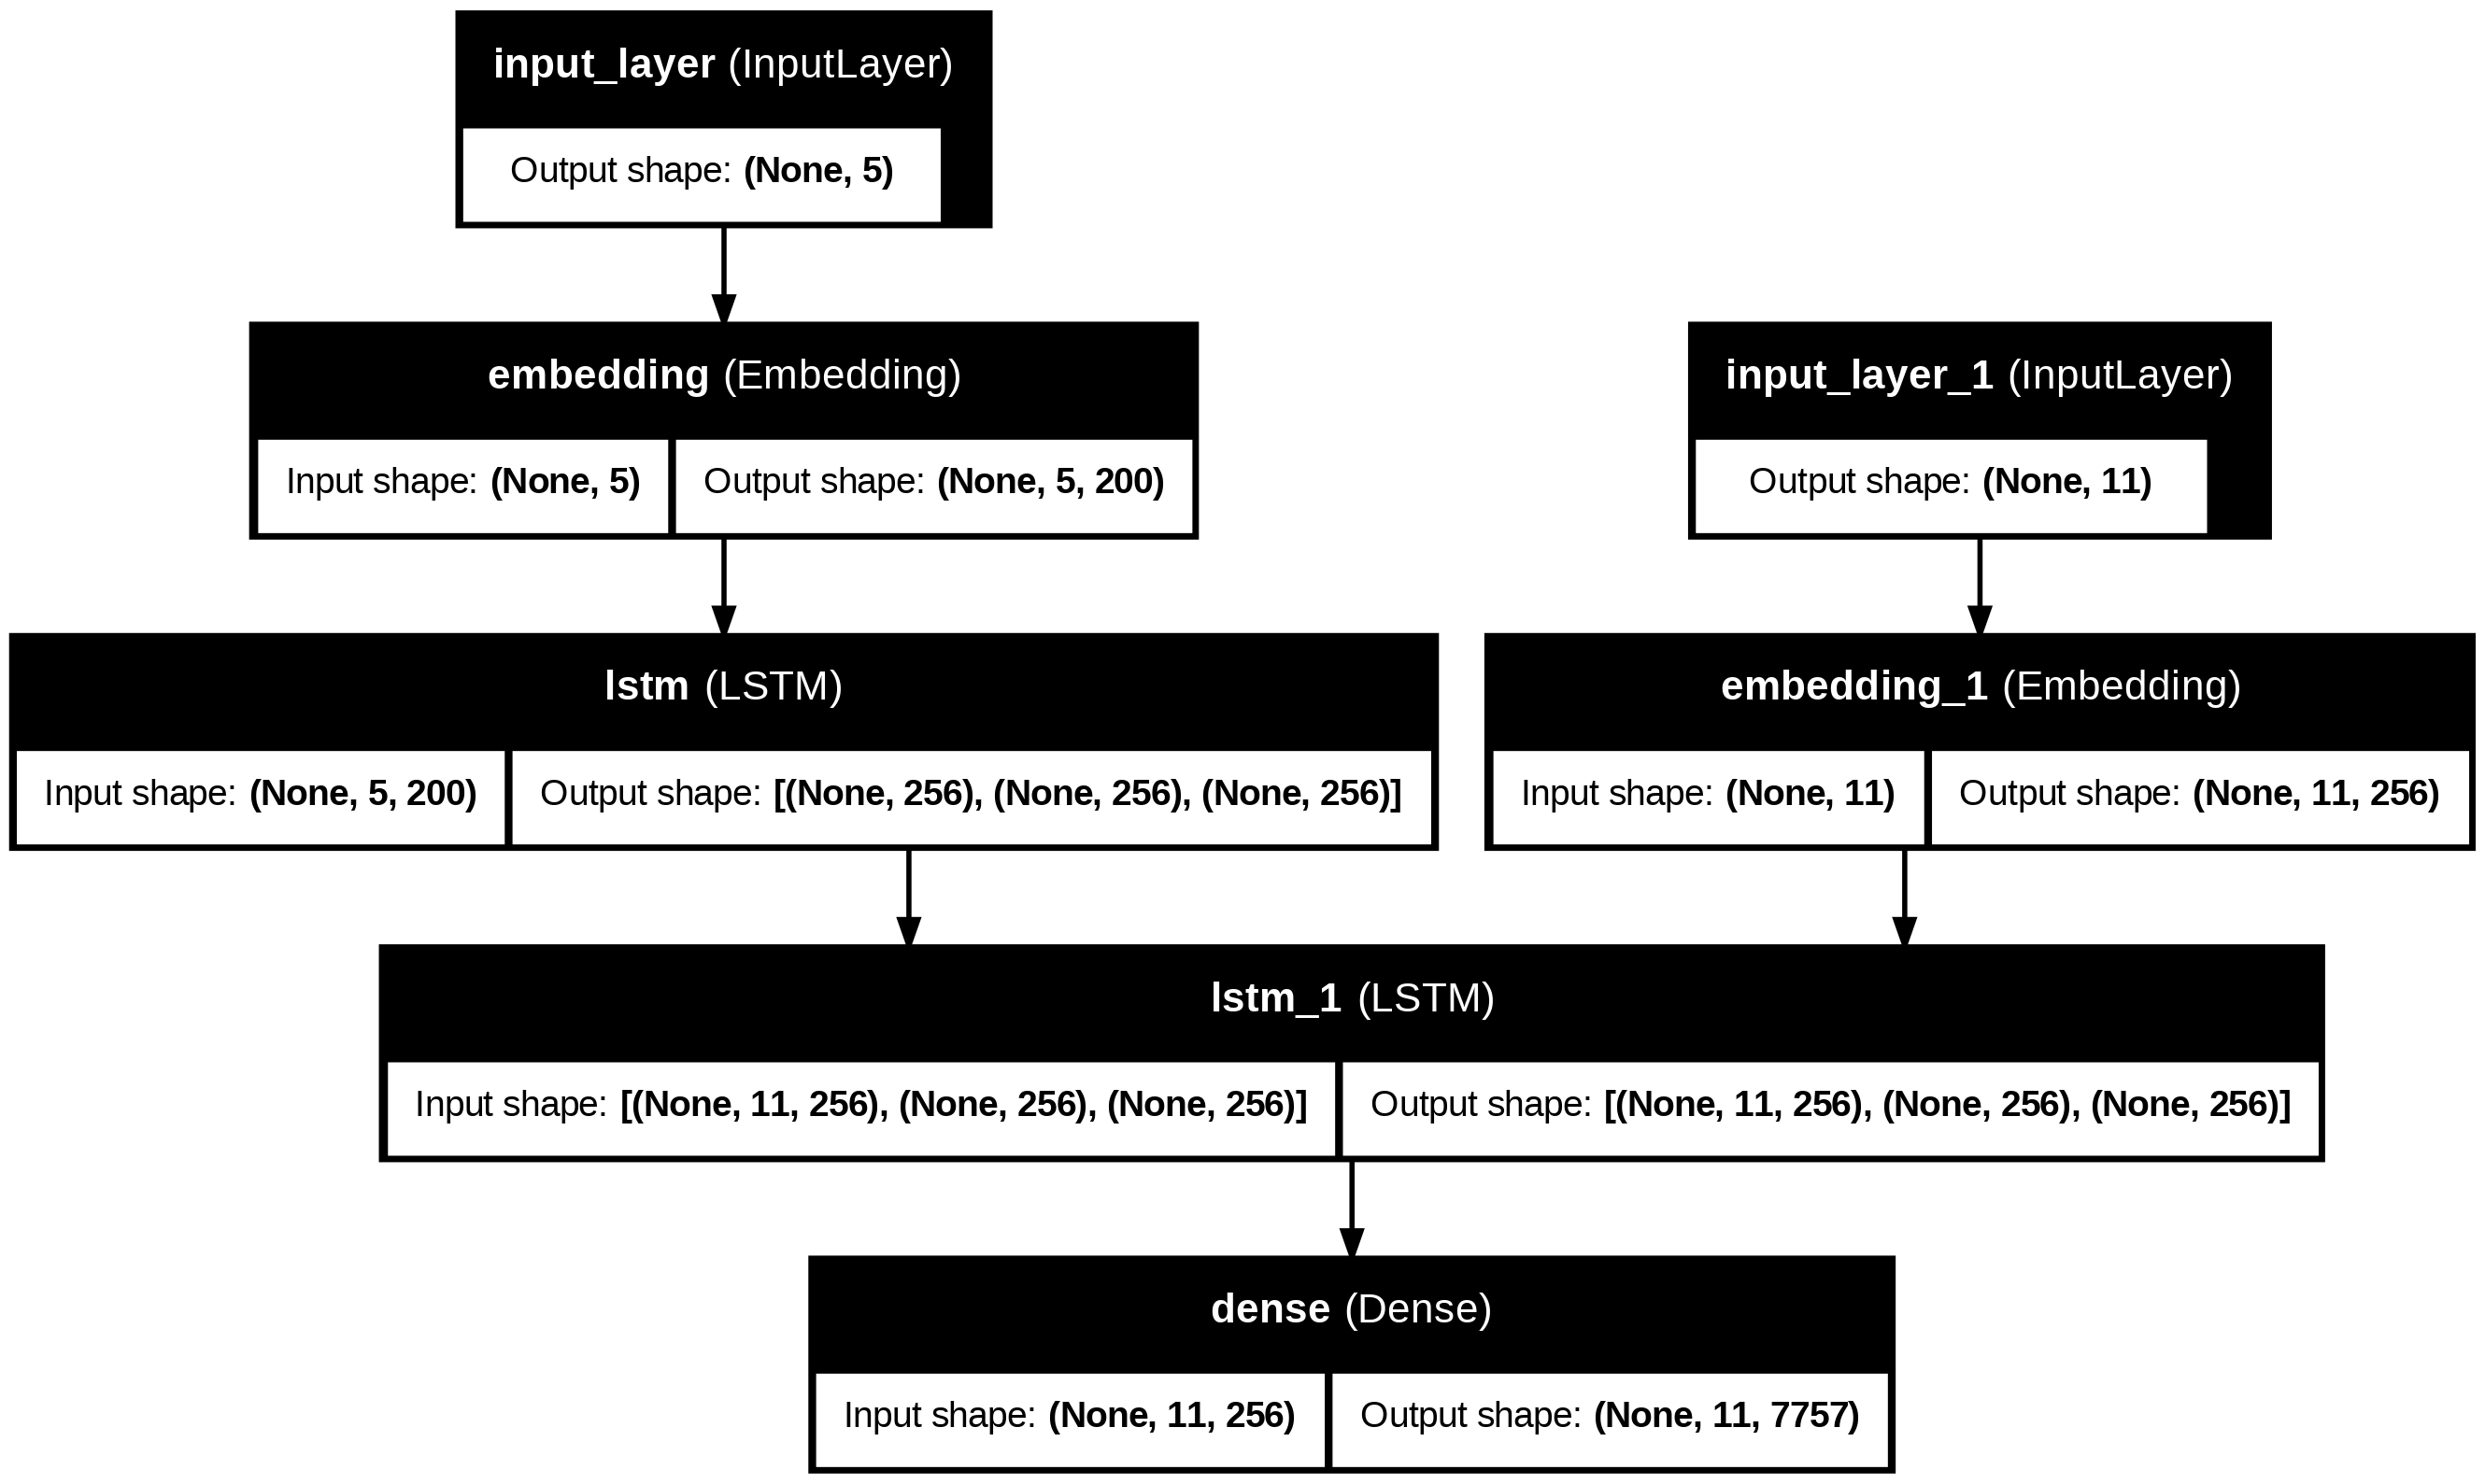

In [29]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [61]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, min_delta = 0.01, patience = 2)

In [26]:
history = []

In [83]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [84]:
with tf.device('/CPU:0'):
    temp_history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
        batch_size=BATCH_SIZE,
        epochs=20,
        callbacks=[es],
        validation_split=0.1,
    )
    history.append(temp_history)

Epoch 1/20
282/282 [==============================] - 69s 235ms/step - loss: 0.6399 - accuracy: 0.8964 - val_loss: 1.0994 - val_accuracy: 0.8397


In [65]:
model.save(MODEL_NAME)

### Please Note: Above Model took 8+ Epochs to train, due to low GPU Memory, I had to save weights, clear session and load weights again to train it.

### Due to insufficient memory, history couldn't be saved directly...

In [85]:
upd_history = []
for temp in history:
    upd_history.append([temp.history['loss'], temp.history['val_loss'], temp.history['accuracy'], temp.history['val_accuracy']])

upd_history = np.array(upd_history)

In [29]:
temp = []
for i in upd_history:
    for j in range(i.shape[1]):
        temp.append([i[0][j], i[1][j], i[2][j], i[3][j]])
upd_history = np.array(temp)

In [31]:
upd_history.shape

(10, 4)

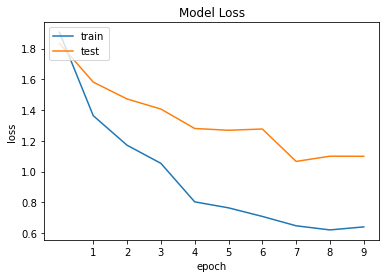

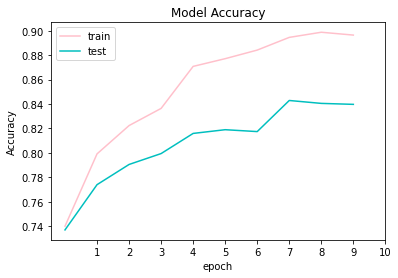

In [87]:
plt.title('Model Loss')
plt.plot(upd_history[:, 0])
plt.plot(upd_history[:, 1])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(1, upd_history.shape[0]))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.title('Model Accuracy')
plt.plot(upd_history[:, 2], c = 'pink')
plt.plot(upd_history[:, 3], c = 'c')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.xticks(range(1, upd_history.shape[0] + 1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights(MODEL_NAME)

In [89]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [90]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [91]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [92]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             1986048     input_8[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

# EVALUATION
Our goal is to produce a string of French words as our output. We must translate the integers back to words in order to accomplish this. For both inputs and outputs, we will construct new dictionaries with words as the corresponding values and integers as the keys.

In [148]:
# Ensure that the NLTK punkt tokenizer is available
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ishan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [217]:
def preprocess_sentence(sentence):
    formatted_seq = re.sub(r'[^\w\s]', '', sentence.lower().strip()) # Strip Whitespaces, lower tokens, remove punctuations
    return word_tokenize(formatted_seq) # tokenize

In [514]:
# Function to find all the references of the given query in the corpus
def find_references(i):
    lower_limit = i
    for j in range(100):
        if (i < j):
            break
        if input_sentences[i - j] != input_sentences[i]:
            lower_limit = j
            break
    total = len(input_sentences)
    upper_limit = total - i
    for j in range(100):
        if (i + j) >= total:
            break
        if input_sentences[i + j] != input_sentences[i]:
            upper_limit = j
            break   

    references = []
    for j in range(i - lower_limit, i + upper_limit):
        if input_sentences[j] == input_sentences[i]:
            references.append(output_sentences[j][:-6])
    return references

In [588]:
def calculate_bleu_score(references, hypothesis_sentence):
    
    flag = False
    # Pre-Process both sentences
    upd_references = []
    for reference in references:
        format_reference = preprocess_sentence(reference)
        if len(format_reference) < 4:
            flag = True
        upd_references.append(format_reference)
    hypothesis = preprocess_sentence(hypothesis_sentence)

    # Calculate BLEU score
    if len(hypothesis) <= 4 or flag:
        bleu_score = corpus_bleu([upd_references], [hypothesis], weights=(1.0, 0, 0, 0))
    else:
        bleu_score = corpus_bleu([upd_references], [hypothesis])
    
    return bleu_score

In [93]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [94]:
# Funtion to translate given query
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<eos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx: # Break, if End of String
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [462]:
# Template Function to print necessities
def automate(i):
    references = find_references(i)
    input_seq = encoder_input_sequences[i:i+1]
    translation = translate_sentence(input_seq)
    print('Input Language : ', input_sentences[i])
    print('Actual translation : ', output_sentences[i][:-6])
    print('French translation : ', translation)
    print('BLEU Score : ', calculate_bleu_score(references, translation))

## Giving Input from Training Corpus Itself

In [450]:
i = np.random.choice(len(input_sentences))
automate(i)

Input Language :  Tom was safe
Actual translation :  Tom était sain et sauf
French translation :  tom était en sécurité
BLEU Score :  1.0


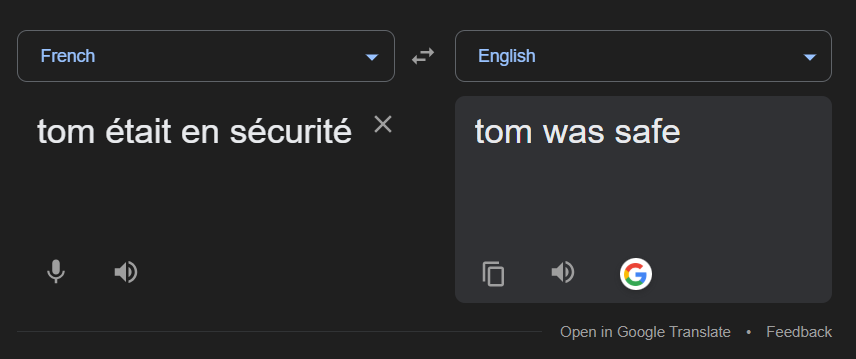

In [454]:
i = np.random.choice(len(input_sentences))
automate(i)

Input Language :  Please stop
Actual translation :  Arrête s'il te plaît
French translation :  s'il vous plaît arrêtez
BLEU Score :  1.0


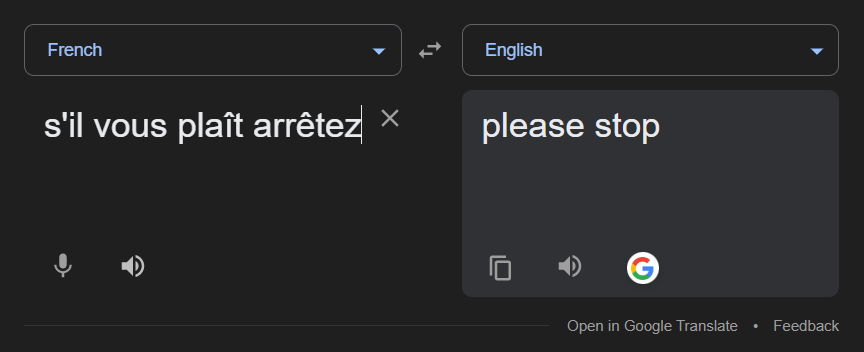

In [458]:
i = np.random.choice(len(input_sentences))
automate(i)

Input Language :  You're foolish
Actual translation :  Tu es imprudent
French translation :  vous êtes êtes
BLEU Score :  0.6666666666666666


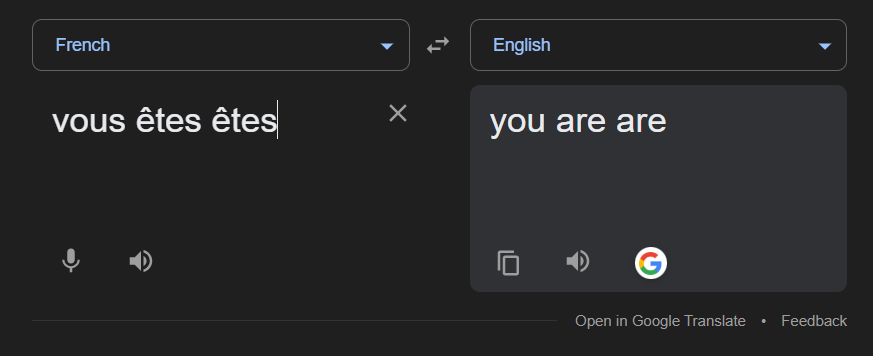

In [461]:
i = np.random.choice(len(input_sentences))
automate(i)

Input Language :  No not at all
Actual translation :  Non pas du tout
French translation :  non pas du tout
BLEU Score :  1.0


# Calculating Average BLEU Score

In [532]:
bleu_dict = defaultdict(list)
bleu_scores = []
total = len(input_sentences)
last_progress = 0
bar = '|' + '>' + ' ' * 100 + '|'
count = 0
for i in range(total):
    references = find_references(i)
    print("Current Processing Phrase: ", input_sentences[i])
    input_seq = encoder_input_sequences[i:i + 1]
    translation = translate_sentence(input_seq)
    bleu = calculate_bleu_score(references, translation) # Calculate BLEU Score
    
    # Printing the Progress / Progress Bar
    clear_output(wait=True)
    progress = 100*(i + 1)/total
    if int(progress) > last_progress:
        bar = '|' + '=' * int(progress) + '>' + ' ' * (100 - int(progress)) + '|'
    print('Progress:', '%.2f' %(progress), '%')
    print('Progress Bar: ', bar)

    bleu_scores.append(bleu)
    words = len(input_sentences[i].split())
    bleu_dict[words].append(bleu)

clear_output(wait=True)
bar = '|' + '=' * 100 + '>' + '|'
print('Progress:', '%.2f' %(100.00), '%')
print('Progress Bar: ', bar)
avg_bleu = sum(bleu_scores) / (total * 1.0)
print("\n\nAverage BLEU Score : ", avg_bleu)

Progress: 100.00 %
Progress Bar:  |====================================================================================================>|


Average BLEU Score :  0.6375314297686242


### Upon iterating over te entire corpus, the Average BLEU Score comes out to be 0.63753, which is pretty decent for a model trained over very small dataset.

# Analyzing BLEU Scores Over Different Query Lengths

In [566]:
query_len = []
len_freq = []
len_bleu = []
for words, _ in bleu_dict.items():
    query_len.append(words)
    len_freq.append(len(_))
    len_bleu.append(sum(_) / (len(_) * 1.0))

for word, bleu, freq in zip(query_len, len_bleu, len_freq):
    print("Word Length: ", word, "\nFrequency: ", freq)
    print("Average BLEU Score: ", '%.5f' %(bleu))
    print()

Word Length:  1 
Frequency:  164
Average BLEU Score:  0.62581

Word Length:  2 
Frequency:  5210
Average BLEU Score:  0.63348

Word Length:  3 
Frequency:  10677
Average BLEU Score:  0.65255

Word Length:  4 
Frequency:  3888
Average BLEU Score:  0.60446

Word Length:  5 
Frequency:  59
Average BLEU Score:  0.51131



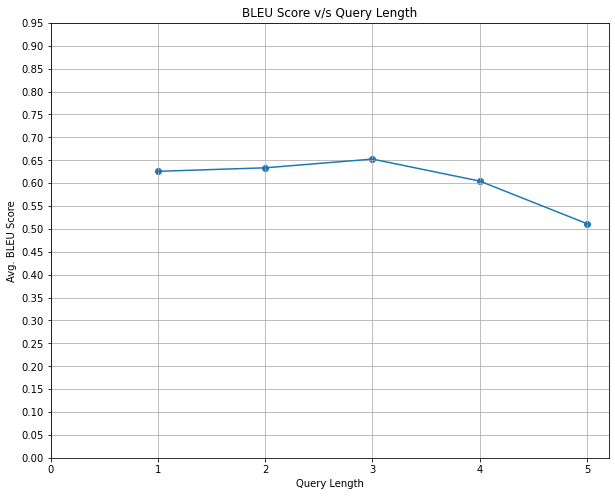

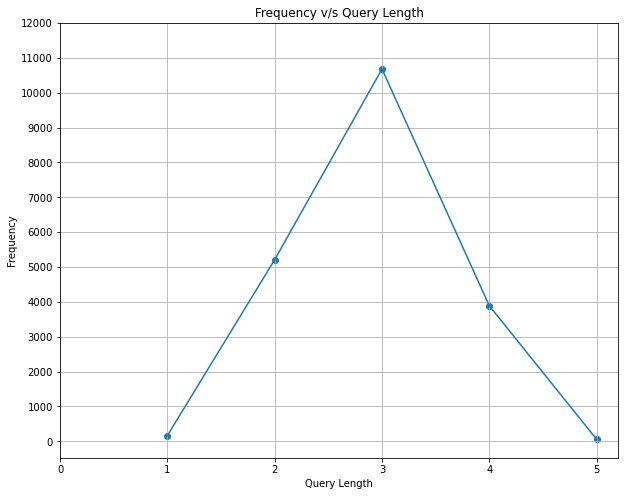

In [563]:
# Analysing BLEU Score v/s Query Length
plt.figure(figsize = (10,8))
plt.plot(query_len, len_bleu)
plt.scatter(query_len, len_bleu)
plt.title("BLEU Score v/s Query Length")
plt.xlabel("Query Length")
plt.xticks(np.arange(0, max(query_len) + 1))
plt.ylabel("Avg. BLEU Score")
plt.yticks(np.arange(0, 1.0, 0.05))
plt.grid()
plt.show()

# Analysing Frequency v/s Query Length
plt.figure(figsize = (10,8))
plt.plot(query_len, len_freq)
plt.scatter(query_len, len_freq)
plt.title("Frequency v/s Query Length")
plt.xlabel("Query Length")
plt.xticks(np.arange(0, max(query_len) + 1))
plt.ylabel("Frequency")
plt.yticks(np.arange(0, max(len_freq) + 2000, 1000))
plt.grid()
plt.show()

It can be seen that majority of our phrases are of length __three__, which has an __Average BLEU Score__ of __0.65281__.

# Translating Phrases
__Our initial project focuses on translating English queries into French phrases. Let's delve into it!__

In [342]:
def translate(query):
    processed_query = format_phrase(query.strip()) # Format the query (punctuations and leading/trailing spaces removed)
    query_seq = input_tokenizer.texts_to_sequences([processed_query]) # Generate Sequence from text
    input_seq = pad_sequences(query_seq, maxlen=max_input_len) # Pad Sequences
    translation = translate_sentence(input_seq)
    print('Input Language : ', query)
    print('French translation : ', translation)

In [343]:
translate("I am going school")

Input Language :  I am going school
French translation :  je me l'école


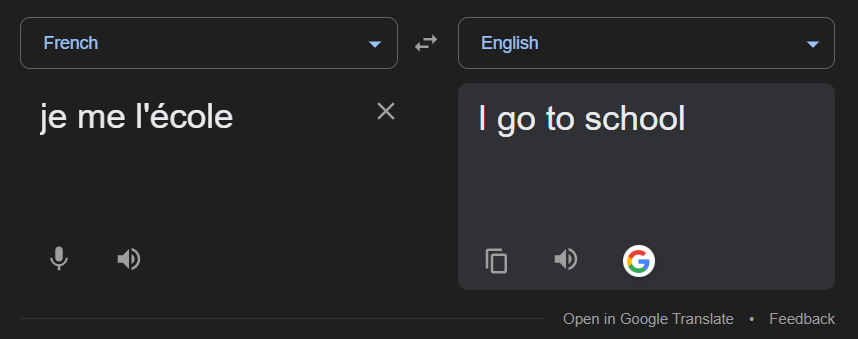

In [345]:
translate("Good Job!")

Input Language :  Good Job!
French translation :  bon boulot


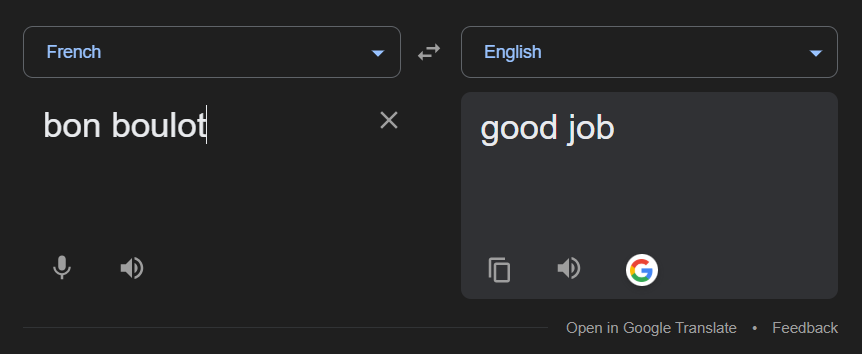

In [350]:
translate("Done and Dusted")

Input Language :  Done and Dusted
French translation :  ils a fait de nouveau


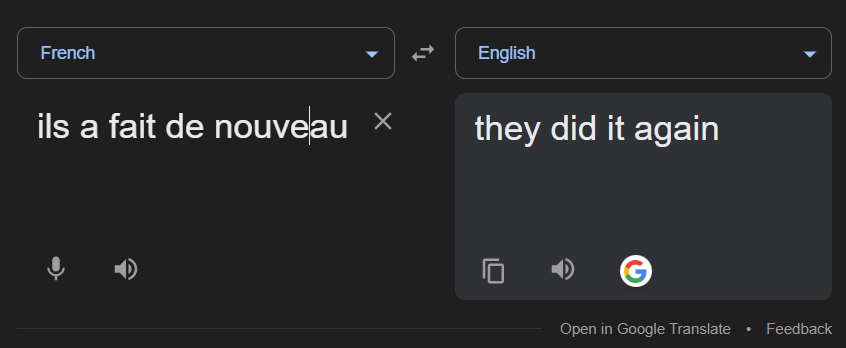

In [349]:
translate("They did it again")

Input Language :  They did it again
French translation :  ils ont fait encore une fois


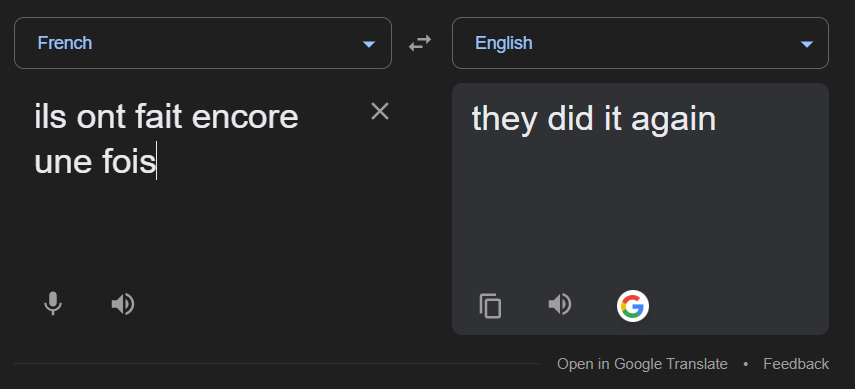

In [493]:
translate("It is bad")

Input Language :  It is bad
French translation :  c'est mauvais


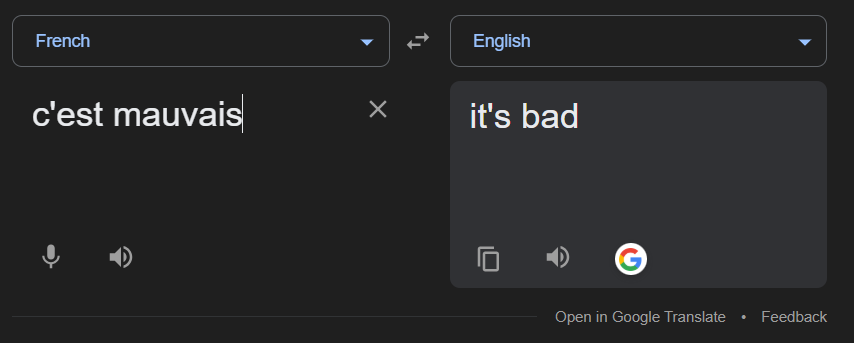

# Conclusions

Since, we did not train our model on all the available unique words and took only top 20k sentences, it is still missing a large proportion of dataset, originally 200k+ sentences for each language.  

Also, since this filtering was done, majority of the rare words were lost.  

Average Phrase Length after filtering came out to be 5 in English and 11 in French (last word was <eos>). This renders our model typically useless for queries larger than the length of 5 words in English.